In [1]:
import pickle

import humanize
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload

In [2]:
# Oversampled
timestamp = '20180509221611'
final_features = pd.read_pickle('./final_features-{}.pkl'.format(timestamp))
outcomes = pd.read_pickle('./labels-{}.pkl'.format(timestamp))

In [3]:
# Take out 5% of data for final final testing; shuffle first

final_features['stop_outcome'] = outcomes
final_features = shuffle(final_features, random_state=0)
outcomes = final_features.pop('stop_outcome')


lop_off_pct = .05
lop_off_idx = round(final_features.shape[0] * lop_off_pct)
print('lop_off_idx = {}'.format(lop_off_idx))

final_test_features = final_features[:lop_off_idx]
final_test_outcomes = outcomes[:lop_off_idx]

final_features = final_features[lop_off_idx:]
outcomes = outcomes[lop_off_idx:]

lop_off_idx = 50452


In [4]:
# Non-oversamled
# timestamp = '20180509221611'
# final_features = pd.read_pickle('./final_features-{}-non_oversampled.pkl'.format(timestamp))
# outcomes = pd.read_pickle('./labels-{}-non_oversampled.pkl'.format(timestamp))

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_outcomes = le.fit_transform(outcomes)

In [6]:
from sklearn.model_selection import train_test_split

# # Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_features, 
                                                    encoded_outcomes, 
                                                    test_size=0.2, 
                                                    random_state=0)


In [7]:
# Take out 5% of data for final final testing; shuffle first
# final_features = shuffle(final_features, random_state=0)

# lop_off_pct = .05
# lop_off_idx = round(X_train.shape[0] * lop_off_pct)
# print('lop_off_idx = {}'.format(lop_off_idx))

# final_test_features = X_train[:lop_off_idx]
# final_test_outcomes = y_train[:lop_off_idx]

# X_train = X_train[lop_off_idx:]
# y_train = y_train[lop_off_idx:]

In [8]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot


In [9]:
xg_train = xgb.DMatrix(X_train.values, label=y_train)
xg_test = xgb.DMatrix(X_test.values, label=y_test)
xg_test_2 = xgb.DMatrix(final_test_features.values, label=le.fit_transform(final_test_outcomes))

In [10]:
params = {
    'objective': 'multi:softmax',
    'learning_rate': 0.0983,
    'max_depth': 19,
    'silent': 0,
    'nthread': 8,
#     'num_class': 45,
#     'predictor': 'gpu_predictor',
#     'max_bin': 512,
    'tree_method': 'gpu_hist',
#     'alpha': 0.8,
#     'gamma': 10.0,
    'subsample': 0.9,
#     'lambda': 0.9,,
#     'colsample_bytree': 0.9,
#     'colsample_bylevel': 0.3,
#     'scale_pos_weight': 0.1,
#     'updater': 'grow_histmaker,refresh,prune',
#     'grow_policy': 'lossguide',
#     'max_leaves': 20000,
#     'max_bin': 1024,
#     'base_score': 1.0,
#     'eval_metric': 'merror',
#     'max_delta_step': 8,
}

params['num_class'] = len(list(final_features.columns.values))

# model = XGBClassifier(xgb_params)
# num_rounds = 3
# model = xgb.train(xgb_params, xg_train, num_rounds)

# n_estimators = [500, 1500, 2500]
# max_depth = [5, 12, 19]
# n_estimators = [5, 10]
# max_depth = [2]

# param_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
# }
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [11]:
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 1000
# num_round = 5

bst = xgb.train(params=params, dtrain=xg_train, num_boost_round=num_round, evals=watchlist, early_stopping_rounds=10)
# bst = xgb.train(params=params, dtrain=xg_train, num_boost_round=num_round, evals=watchlist)

[0]	train-merror:0.383538	test-merror:0.395415
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 10 rounds.
[1]	train-merror:0.337566	test-merror:0.35532
[2]	train-merror:0.310191	test-merror:0.331515
[3]	train-merror:0.289116	test-merror:0.312586
[4]	train-merror:0.271925	test-merror:0.297298
[5]	train-merror:0.259175	test-merror:0.285208
[6]	train-merror:0.248352	test-merror:0.275902
[7]	train-merror:0.238152	test-merror:0.266868
[8]	train-merror:0.229307	test-merror:0.258575
[9]	train-merror:0.222397	test-merror:0.252368
[10]	train-merror:0.214422	test-merror:0.24554
[11]	train-merror:0.207869	test-merror:0.239772
[12]	train-merror:0.202116	test-merror:0.234503
[13]	train-merror:0.196931	test-merror:0.229632
[14]	train-merror:0.19231	test-merror:0.225496
[15]	train-merror:0.187734	test-merror:0.220947
[16]	train-merror:0.18333	test-merror:0.216967
[17]	train-merror:0.179635	test-merror:0.213515
[18

In [12]:
pred = bst.predict(xg_test)

In [13]:
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Test error using softmax = {}'.format(error_rate))

Test error using softmax = 0.06187147924055915


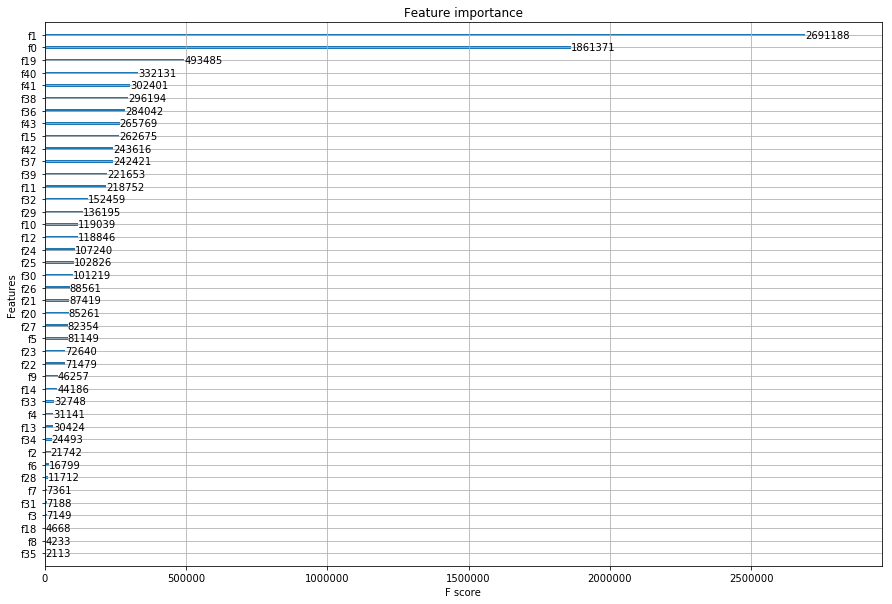

In [14]:
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(15, 10)

In [15]:
for idx, c in enumerate(final_features.columns.values):
    print('{}: {}'.format(idx, c))

0: location_raw
1: driver_age_raw
2: search_conducted
3: contraband_found
4: violation_bad_stop
5: violation_cell_phone
6: violation_display_of_plates
7: violation_equipment
8: violation_license
9: violation_lights
10: violation_moving_violation
11: violation_other
12: violation_registration
13: violation_safe_movement
14: violation_seatbelt
15: violation_speeding
16: violation_suspended_license
17: violation_traffic_control_signal
18: violation_window_tint
19: is_male
20: county_name_Fairfield County
21: county_name_Hartford County
22: county_name_Litchfield County
23: county_name_Middlesex County
24: county_name_New Haven County
25: county_name_New London County
26: county_name_Tolland County
27: county_name_Windham County
28: driver_race_Asian
29: driver_race_Black
30: driver_race_Hispanic
31: driver_race_Other
32: driver_race_White
33: stop_duration_1-15 min
34: stop_duration_16-30 min
35: stop_duration_30+ min
36: day_period_Afternoon
37: day_period_Evening
38: day_period_Morning


In [16]:
pred_2 = bst.predict(xg_test_2)

In [22]:
error_rate = np.sum(pred_2 != le.fit_transform(final_test_outcomes)) / final_test_outcomes.shape[0]
print('Test error using softmax [test_2] = {}'.format(error_rate))

Test error using softmax [test_2] = 0.06156346626496472


In [ ]:
from sklearn.utils import shuffle

ff2 = final_features.copy(deep=True)
ff2['stop_outcome'] = outcomes

ff2 = shuffle(ff2, random_state=8, n_samples=100000)
ff2_outcomes = le.fit_transform(ff2.pop('stop_outcome'))

xg_test_3 = xgb.DMatrix(ff2.values, label=ff2_outcomes)

pred_3 = bst.predict(xg_test_3)

error_rate_3 = np.sum(pred_2 != ff2_outcomes) / ff2_outcomes.shape[0]

print('Test error using softmax [test_3] = {}'.format(error_rate_3))

In [23]:
pickle.dump(bst, open('runs/201805100107-0.062-error-oversampled-bst.pkl', 'wb'))

In [ ]:
# from datetime import datetime
# import pickle

# timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

# pickle(bst, open('{}-bst.pkl'.format(timestamp), 'wb')
# pickle(pred, open('{}-pred.pkl'.format(timestamp), 'wb')


### Plot results

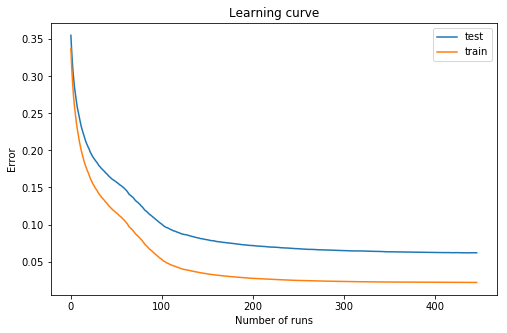

In [24]:
error_results = {
    'train': [],
    'test': [],
}

with open('xgboost-447_run-201805100107.log', 'r') as f:
    for line in f:
        tokens = line.strip().split('\t')
        error_results['train'].append(float(tokens[1].split(':')[1]))
        error_results['test'].append(float(tokens[2].split(':')[1]))

df_errors = pd.DataFrame(error_results)

learning_curve = df_errors.plot.line(title='Learning curve', figsize=(8,5))
learning_curve.set_xlabel('Number of runs')
learning_curve.set_ylabel('Error')

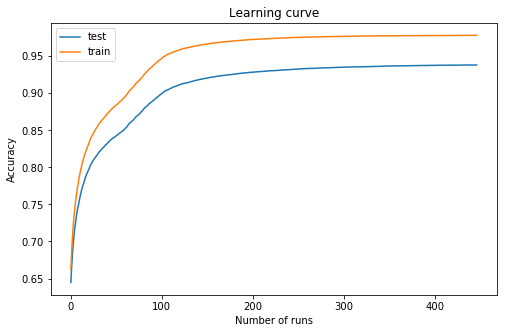

In [25]:
df_accuracy = df_errors.copy()
df_accuracy_processed = df_accuracy.mul(-1).add(1)

learning_curve = df_accuracy_processed.plot.line(title='Learning curve', figsize=(8,5))
learning_curve.set_xlabel('Number of runs')
learning_curve.set_ylabel('Accuracy')